<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Neuropixels Extracellular Electrophysiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 22, 2018</h3> 

<img src="../resources/EphysObservatory/neuropixels.png" height="250" width="250"> 

# Initial setup

To be merged with earlier sections of notebook

In [25]:
# first we need a bit of import boilerplate
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import allensdk.brain_observatory.ecephys.ecephys_session as ecephys_session

# fix slow autocomplete
%config Completer.use_jedi = False

In [26]:
manifest_path = os.path.join('/local1/storage/allensdk_cache/example_ecephys_project_cache', 'manifest.json')

cache = EcephysProjectCache.from_lims(
    manifest=manifest_path,
    lims_kwargs={
        "pg_kwargs": {
            "dbname": "lims2_nileg",
            "host": "aibsdc-dev-db1",
            "port": 5432,
            "user": "limsreader",
            "password": "limsro"
        },
        "app_kwargs": {
            "host": "axon:4000"
        }
    }
)

In [27]:
# This will use a session object from earlier portions. 
session_id = 797828357 # for example
session = cache.get_session_data(session_id)

## Local Field Potential (LFP)

The final aspect of a Neuropixels probe recording we will investigate is the local field potential (LFP). An LFP signal is a direct recordings of extracellular voltage from which individual spike contributions have been removed by low-pass filtering. The remaining signal reflects the population activity of a large number of cells in the vicinity of the probe, primarily through the electrical field effects of synaptic currents (along with other trans-membrane currents).

LFP can be especially informative for understanding rhythmic activity or oscillations in neural circuits, which can be identified by some simple time-series analysis of the LFP signals.

### Accessing data

We'll start by loading the LFP data from one of the probes in our session.

We need to provide this function with a probe id, which we can pull out of the `session.probes` table. 

(Note that the "id" column is the index of the dataframe, and thus must be accessed differently than other columns.)

In [28]:
probe_id = session.probes.index[0]
lfp = session.get_lfp(probe_id)
print(lfp)

KeyboardInterrupt: 

### Plot the LFP time series

To visualize this data, we'll first use the built-in xarray plotting to generate a quick plot. This is too much data to plot all at once, so we select a subset first. Just as in pandas, we use the `loc` property, but since xarray has named dimensions, we can specify our selections by name rather than by order, using a dict.

In [ ]:
channel = lfp.channel[0]
subset = lfp.loc[dict(channel=channel, time=slice(5,15))]

plt.figure(figsize=(12,3))
subset.plot()

We might also want to visualize a specific frequency band by filtering. To do this we'll want to convert our data into standard numpy arrays for easier processing using the DataArray object's `values` property.

In [ ]:
t = lfp.time.values
v = lfp.isel(channel=0).values

In [ ]:
import scipy.signal
freq_window = (4, 15)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)


window = [5, 15]
idx = np.logical_and(t>=window[0], t<window[1])
plt.figure(figsize=(12,3))
plt.plot(t[idx], v[idx])
plt.plot(t[idx], v_alpha[idx],'k')

## Spectral analysis


Next we're going to analyze some spectral properties of this signal using the `scipy.signal` library. "Spectral" refers to decomposing a signal into a sum of simpler components identified by their frequencies. The set of frequencies of the components forms a *spectrum* that tells us about the complete signal. You can see a full list of spectral analysis functions in scipy here: https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis

### Power spectral density (PSD)

We first import the package, and inspect the `periodogram` function, which estimates the size of the different frequency components of the signal.

** Note: maybe we want to compute this directly from an FFT? but only if that concept is already meaningful, so maybe not...**

In [ ]:
import scipy.signal
help(scipy.signal.periodogram)

There are a number of options that we won't go into here for refining the analysis. The one piece of information we do need is `fs`, the sampling frequency. If we used the default value `fs=1.0` our results would not match the true frequencies of the signal.

In [ ]:
fs = 1/(t[1]-t[0])
window = [10, 100]
idx = np.logical_and(t>=window[0], t<window[1])

f, psd = scipy.signal.periodogram(v[idx], fs)

We'll plot the power spectrum on a semilog plot, since power can vary over many orders of magnitude across frequencies.

In [ ]:
plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

We see that this representation of the power spectrum is extremely noisy. Luckily, many people have come up with solutions to this problem. Scipy includes a function for Welch's method, which averages out noise by computing many estimates of the power spectrum from overlapping windows of the data. You can find some more references for this approach in the Scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

In [ ]:
f, psd = scipy.signal.welch(v[idx], fs, nperseg=1000)

plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

In [ ]:
imax = np.argmax(psd)
print(f"Max at {f[imax]} Hz")

### Calculate and plot the time-frequency profile ("spectrogram")

We might also be interested in how the frequency content of the signal varies over time. In a neural context, power in different frequency bands is often linked to specific types of processing, so we might explore whether changes in the spectrum coincide with specific behaviors or stimuli.

The *spectrogram* is essentially an estimate of the power spectrum computed in a sliding time window, producing a 2D representation of the signal power across frequency and time.

In [17]:
window = [10, 20]
idx = np.where(np.logical_and(t>=window[0],t<window[1]))[0]

f, t_spec, spec = scipy.signal.spectrogram(v[idx], fs=fs, window='hanning',
                            nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[window[0]]

We'll use the matplotlib `pcolormesh` function to visualize this data as an image. We can pass this function grids of x and y coordinates to get the axis labeling right. We also log-transform the power spectrum and restrict to frequencies less than 100 Hz.

In [18]:
fmax = 80
x_mesh, y_mesh = np.meshgrid(t_spec, f[f<fmax])
plot_data = np.log10(spec[f<fmax])

We'll plot the spectrum together with the raw signal in subplots. Note that we explicitly set the x-axis limits to align the plots. (Alternatively, it's possible to directly couple the limits of different subplots.)

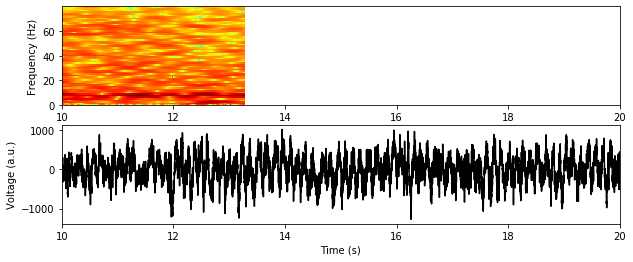

In [19]:
from matplotlib import cm
plt.figure(figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x_mesh, y_mesh, plot_data, cmap=cm.jet)
plt.xlim(window)
plt.ylabel('Frequency (Hz)')

plt.subplot(2,1,2)
plt.plot(t[idx], v[idx], 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.show()

## Current source density (CSD) analysis

Physically, the LFP is made up of the electric fields from specific current sources (or sinks) in brain tissue, namely individual trans-membrane currents. Under certain simplifying assumptions, this transformation of spatial current distribution into field potential can be inverted to infer the distribution of currents underlying a measurement. This is called the current source density, or CSD. Spatial properties of the LFP are generally better studied in this representation.

We have pre-calculated estimates of CSD for each probe during a subset of stimulus presentations, which we access below. Note that the CSD array contains data for 186 channels (half the total), in contrast to the LFP which is only provided for approximately one quarter of the contacts.

In [20]:
csd = session.get_current_source_density(probe_id)
csd

<xarray.DataArray 'CSD' (channel: 186, time: 3250)>
array([[  1448.822115,  16253.509615,  -2223.052885, ...,   -582.427885,
         -4644.927885,  17191.009615],
       [ 17564.6875  ,   4478.75    , -13841.5625  , ..., -44154.0625  ,
          9595.9375  ,   6783.4375  ],
       [ 10111.177885,   2923.677885, -11998.197115, ..., -35435.697115,
         19447.115385,   5892.427885],
       ...,
       [ -3101.694712,   8890.492788,  -7320.444712, ...,  10687.367788,
          8226.430288,  -5015.757212],
       [ -2231.814904,  11166.622596,  14213.497596, ...,  21791.622596,
          5502.560096, -22192.752404],
       [ -5571.923077,  -6235.985577,   1928.076923, ...,  -3735.985577,
        -24321.923077, -13696.923077]])
Coordinates:
  * channel  (channel) uint64 849856764 849856768 ... 849857500 849857504
  * time     (time) float64 -0.3 -0.2996 -0.2992 ... 0.9988 0.9992 0.9996

***Maybe move this elsewhere***

We can figure out where each LFP channel is located in the brain using the function `ecephys_session.intervals_structures`, which will identify channels that serve as reference points for the boundaries between identified brain regions.

In [21]:
# pass in the list of channels from the CSD
channels = session.channels.loc[csd.channel]
structure_acronyms, intervals = ecephys_session.intervals_structures(channels)
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
print(structure_acronyms)
print(interval_midpoints)

['TH' 'DG' 'CA' 'VISam' 'None']
[11.5, 48.0, 93.0, 140.5, 177.0]


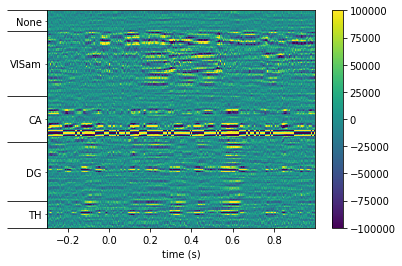

In [22]:
fig, ax = plt.subplots()

xmesh, ymesh = np.meshgrid(csd.time, range(len(csd.channel)))
plt.pcolormesh(xmesh, ymesh, csd, vmin=-1e5, vmax=1e5)
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")
ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)

# make the long divider lines between intervals
plt.tick_params("y", which="major", labelleft=False, length=40)
plt.show()

***Equivalent plot using xarray***

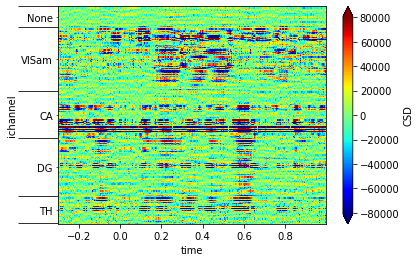

In [23]:
fig, ax = plt.subplots()
csd.coords['ichannel']=('channel',range(len(csd.channel)))
csd.plot(x='time', y='ichannel', robust=True, cmap=cm.jet)

ax.set_yticks(intervals)
plt.tick_params("y", which="major", labelleft=False, length=40)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.show()

# Exercises

### Spike-triggered average of LFP

### Hilbert transform and instantaneous amplitude

Another way to analyze how an oscillatory signal varies with time is to extract its instantaneous amplitude using a mathematical tool called the Hilbert transform. The function `scipy.signal.hilbert` adds a second dimension to a signal (as a complex variable), such that the resulting *analytic signal* now has a well-defined nonzero amplitude and phase at every instant in time! (See http://www.rdgao.com/roemerhasit_Hilbert_Transform/ for a nice explanation.)

- First, calculate the analytic signal from your alpha filtered LFP
- Then use `np.abs` and `np.angle` to calculate the amplitude and phase of the signal. Visualize the filtered LFP along with its amplitude and phase.

(-5.34109429488252, 5.026705545819652, -4.642599814984279, 5.725200025717894)

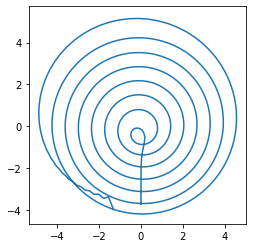

In [24]:
lfp_z = scipy.signal.hilbert(v_alpha)
lfp_amp = np.abs(lfp_z)
lfp_phase = np.angle(lfp_z)

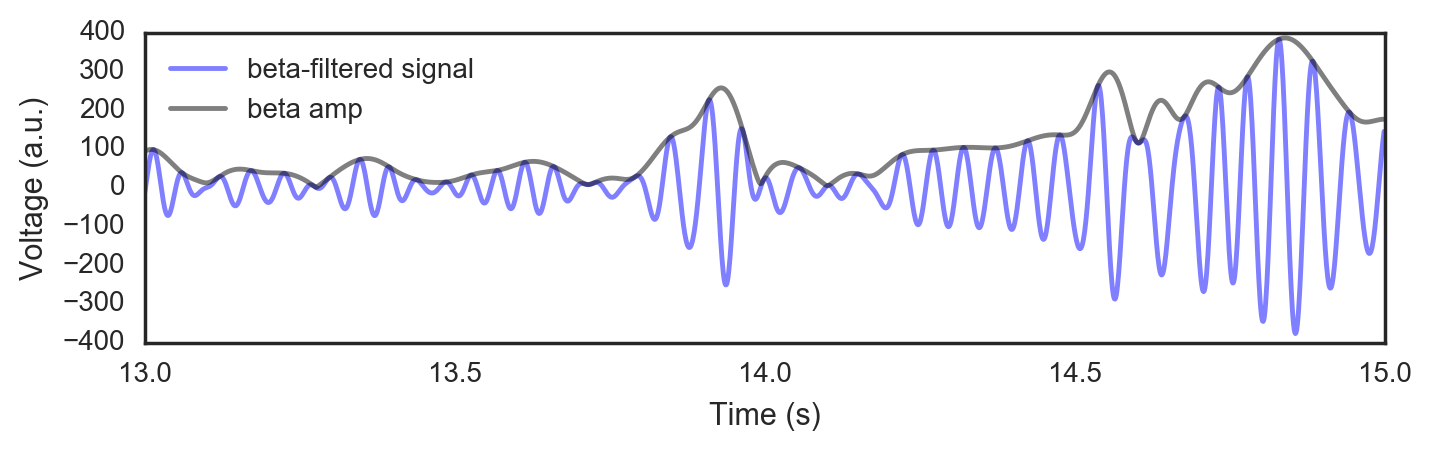

In [21]:
idx = np.logical_and(t>=window[0], t<window[1])
window = [5, 15]

plt.figure(figsize=(8,2))
plt.plot(t[idx], v_alpha[idx],'b',label='beta-filtered signal',alpha=.5)
plt.plot(t[idx], lfp_amp[idx],'k',label='beta amp',alpha=.5)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')

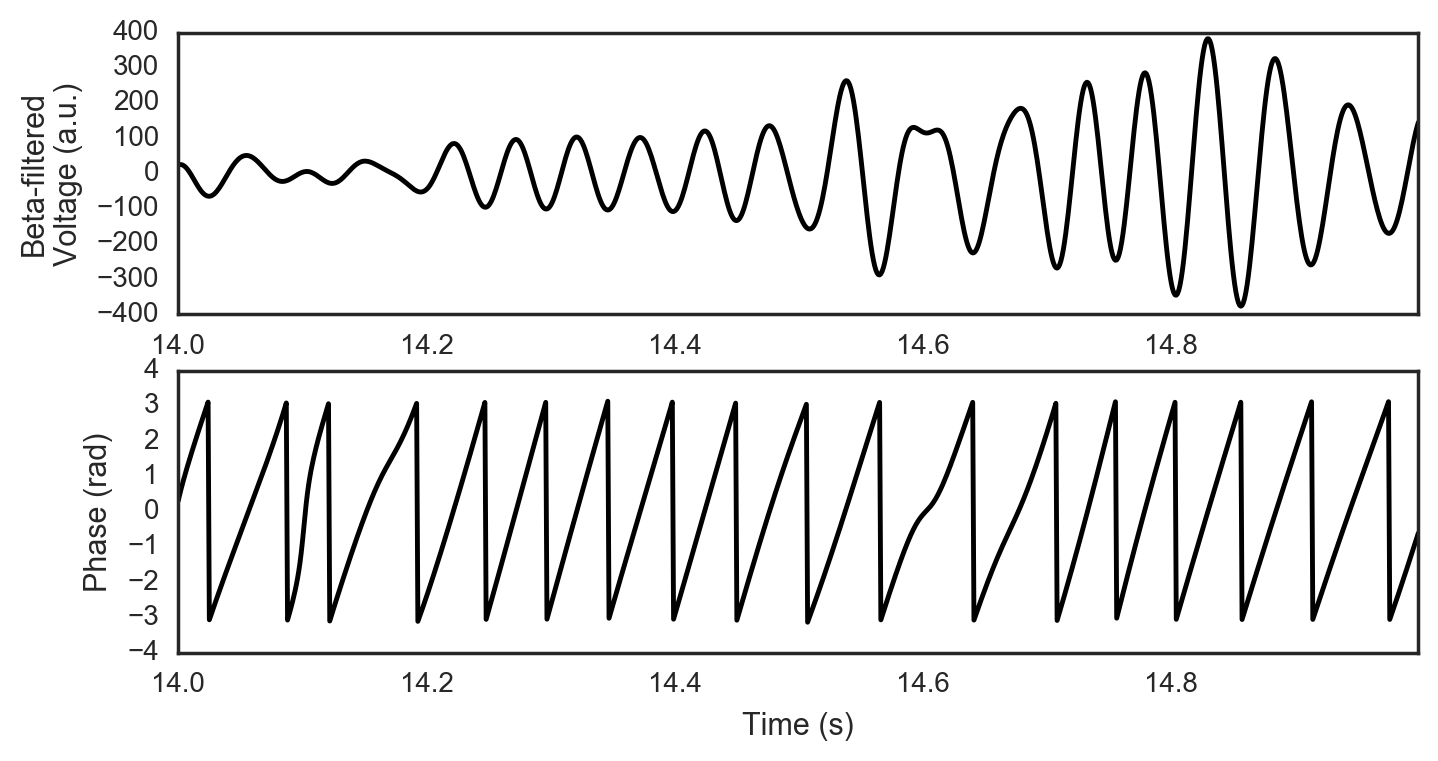

In [22]:
beta_phase = np.angle(sp.signal.hilbert(x_filt))

samp_plot = range(14000,15000)
plt.figure(figsize=(8,4))
plt.subplot(3,1,1)
plt.plot(t[idx], v_alpha[idx],'k')
plt.ylabel('Beta-filtered\nVoltage (a.u.)')
plt.subplot(3,1,1)
plt.plot(t[idx], lfp_amp[idx],'k')
plt.ylabel('Amplitude (uV)')
plt.subplot(3,1,2)
plt.plot(t[idx], lfp_phase[idx],'k')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')